# Route Navigation

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import xarray as xr
import imageProc as pr
import snapShots as snp

import willshaw as wl

In [2]:
plotFolder = "plots/willshawRoute/"

Get activity of VPNs for a single image

In [3]:
rt = 'Ant1_Route1'
zAnt = 0.01 #height of ant in m
frame = 620
visibility = 2 #in m
hfovDeg = 296 #deg
resDeg = 4 #deg
upDeg = 60 #deg
downDeg = -15 #deg

In [4]:
dWorld = pr.extractWorld("data/world5000_gray.mat")

In [5]:
dRoutes, nframes = pr.extractRoutes("data/world5000_gray.mat",zAnt)

In [6]:
I = pr.generateScene(rt, frame, visibility, dWorld, dRoutes, hfovDeg, resDeg, upDeg, downDeg, zAnt).reshape(-1,1)

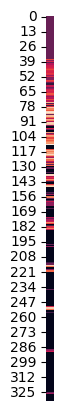

In [7]:
plt.figure(figsize = (0.1,5))
sns.heatmap(I,cbar=False);
plt.savefig(plotFolder + "VPN_activity_sample_scene.png",dpi=300,bbox_inches = 'tight')

In [8]:
nVPNs = len(I)
nKCs = 20000
perKC = 10
KCthresh = 0.6 #enforcing sparsity

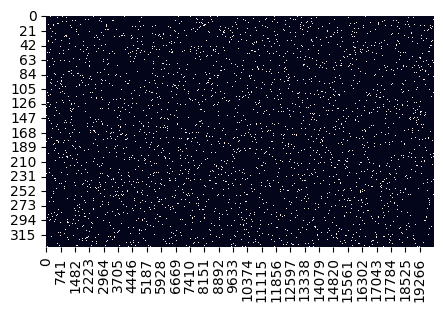

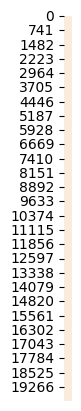

In [9]:
w1, w2t0 = wl.init_willshaw(nVPNs, nKCs, perKC)
plt.figure(figsize = (5,3))
sns.heatmap(w1,cbar=False);
plt.savefig(plotFolder + "w1_matrix_before.png",dpi=300,bbox_inches = 'tight')

plt.figure(figsize = (0.1,5))
sns.heatmap(w2t0,cbar=False,vmin=0);
plt.savefig(plotFolder + "w2_matrix_before.png",dpi=300,bbox_inches = 'tight')

463.0


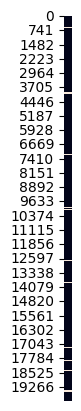

In [10]:
KCt0, MBONt0 = wl.evolve_willshaw(I, w1, w2t0, KCthresh)

plt.figure(figsize = (0.1,5))
sns.heatmap(KCt0,cbar=False,vmin=0,vmax=1);

print(MBONt0[0][0])
plt.savefig(plotFolder + "KC_activity_before_L1.png",dpi=300,bbox_inches = 'tight')

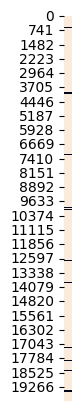

In [11]:
w2t1 = wl.learn_willshaw(KCt0, w2t0)

plt.figure(figsize = (0.1,5))
sns.heatmap(w2t1,cbar=False,vmin=0);
plt.savefig(plotFolder + "w2_matrix_after_L1.png",dpi=300,bbox_inches = 'tight')

0.0


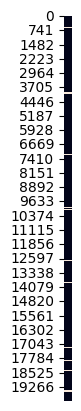

In [12]:
KCt1, MBONt1 = wl.evolve_willshaw(I, w1, w2t1, KCthresh)

plt.figure(figsize = (0.1,5))
sns.heatmap(KCt1,cbar=False,vmin=0,vmax=1);

print(MBONt1[0][0])
plt.savefig(plotFolder + "KC_activity_after_L1.png",dpi=300,bbox_inches = 'tight')

## Learn Snapshots over the Route

In [13]:
snapshots = 50

In [14]:
scenes,snapframes = pr.walkThrough(nframes, rt, snapshots,
               visibility, dWorld, dRoutes, hfovDeg, resDeg, upDeg, downDeg, zAnt)

In [15]:
It = scenes.reshape(-1,scenes.shape[-1])
notnan = ~np.isnan(It[0,:])
It = It[:,notnan]
snapframes = snapframes[notnan]

In [16]:
w1, w2t = wl.init_willshaw(nVPNs, nKCs, perKC)
for i,f in enumerate(range(It.shape[1])):
    KCt, MBONt = wl.evolve_willshaw(It[:,i], w1, w2t, KCthresh)
    w2t = wl.learn_willshaw(KCt, w2t)

Learnt snapshots

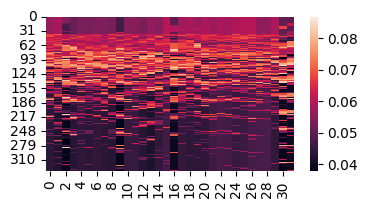

In [17]:
plt.figure(figsize = (4,2))
sns.heatmap(It);
plt.savefig(plotFolder+"learnt_VPN_patterns.png",dpi=300,bbox_inches='tight')

Weights of KC-MBON connections:

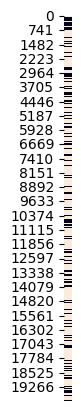

In [18]:
plt.figure(figsize = (0.1,5))
sns.heatmap(w2t,cbar=False,vmin=0);
plt.savefig(plotFolder + "w2_matrix_after_L.png",dpi=300,bbox_inches = 'tight')

Locations and head directions when snapshots were taken

In [19]:
# learnt locations along the route
locs = np.vstack([dRoutes.loc[rt,:,'X'], dRoutes.loc[rt,:,'Y']]).T
learntLocs = locs[snapframes,:]
HDs = np.array(dRoutes.loc[rt,:,'th'])
learntHDs = HDs[snapframes]

Compute home direction

In [20]:
Rt = dRoutes.loc[rt,~np.isnan(dRoutes.loc[rt,:,'X'].values),['X','Y']]
HV = Rt[-1,:]-Rt[0,:]
HD = np.arctan2(HV[1],HV[0])

## Gradient Descent on MBON Activity

### Find direction of minimum MBON activity around the learnt scenes

HD of the ant at which the scene was stored

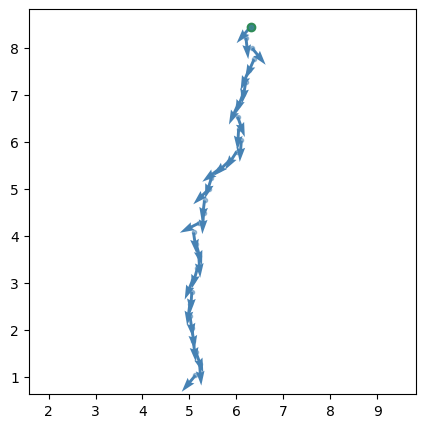

In [21]:
fig, ax = pr.top_view(rt, frame, visibility, dWorld, dRoutes, plotWorld=False, plotFov=False, alpha=0);
plt.plot(learntLocs[:,0], learntLocs[:,1], '.',color='steelblue',alpha=0.5);
plt.quiver(learntLocs[:,0], learntLocs[:,1],np.cos(learntHDs), np.sin(learntHDs),color='steelblue');
plt.savefig(plotFolder + "learnt_locations_and_dir.png",dpi=300,bbox_inches = 'tight')

## Scanning around a learnt scene

In [67]:
learntID = 5 #id of learnt frame

Construct virtual grid around the scene

In [68]:
gridRes = 0.03 #resolution of the grid in metres
gridBound = 1 #boundary around learnt scene
thetaRes = 1 #resolution of scan in degrees
thetaLim = 30 #maximum deviation during scan in degrees

In [69]:
grid, scan, dVirtual = snp.scanLocs(learntID, learntLocs, learntHDs, zAnt,
                                   gridRes, gridBound, thetaRes, thetaLim, HD)

In [70]:
print("number of scenes: ",len(grid)*len(scan))

number of scenes:  2640


Generate VPN activity for direction bins at the scene location

In [ ]:
scenescan,snapframes = pr.walkThrough(dVirtual.shape[1], 0, dVirtual.shape[1],
        visibility, dWorld, dVirtual, hfovDeg, resDeg, upDeg, downDeg, zAnt)

In [ ]:
scanI = scenescan.reshape(-1,scenescan.shape[-1])

In [ ]:
_, descentDir = wl.descendMBONgrad(grid, scan, scanI, w1, w2t, KCthresh)

In [ ]:
fig,ax = plt.subplots(figsize = (5,5))
fig,ax = pr.top_view(rt, snapframes[learntID], visibility, dWorld, dRoutes, plotWorld = False, plotOrigin = False, plotFov=False, fig=fig,ax=ax,alpha=1);

ax.set_xlim(grid[:,0].min(),grid[:,0].max())
ax.set_ylim(grid[:,1].min()-gridRes,grid[:,1].max()+gridRes);

ax.quiver(grid[:,0], grid[:,1],np.cos(descentDir), np.sin(descentDir),color='crimson');
plt.savefig(plotFolder + "output_scan_around_L"+str(learntID)+".png",dpi=300,bbox_inches = 'tight')

## Scan at the Learnt Locations

MBON activity around learnt scenes

In [53]:
thetaRes = 1 #resolution of scan in degrees
thetaLim = 30 #maximum deviation during scan in degrees

In [54]:
def scanOnSpot(learntID, learntLocs, learntHDs, zAnt,
             thetaRes, thetaLim, HD):
    
    scene_loc = learntLocs[learntID]
    scene_hd = learntHDs[learntID]
    scan = np.arange(HD-(thetaLim*np.pi/180),HD+(thetaLim*np.pi/180
                                                    ),thetaRes*np.pi/180)
    common_scan = scan-scene_hd
    
    routes = np.array([np.array([[scene_loc[0], scene_loc[1], zAnt, th] 
                    for th in scan])])
    dVirtual = xr.DataArray(data = routes, coords = {'routes':                              
                    range(1), 'frames': range(routes.shape[1]), 
                    'vars': ['X', 'Y', 'Z', 'th']})
    
    return common_scan, dVirtual

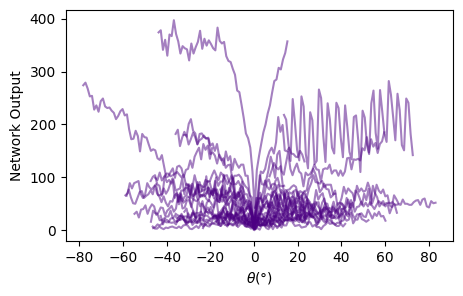

In [55]:
plt.figure(figsize = (5,3))
for learntID in range(np.sum(~np.isnan(learntLocs[:,0]))):
    
    scan, dVirtual = scanOnSpot(learntID, learntLocs, learntHDs, zAnt,
             thetaRes, thetaLim, HD)
    
    LSceneScan = np.zeros([len(scan),333])
    
    for f in range(len(scan)):
            LSceneScan[f,:] = pr.generateScene(0, f, visibility, dWorld, dVirtual,
            hfovDeg, resDeg, upDeg, downDeg, zAnt).reshape(-1,1).T
    
    MBON_scan = np.zeros(len(scan))
    for f in range(len(scan)):
        _, MBON_scan[f] = wl.evolve_willshaw(LSceneScan[f], w1, w2t, KCthresh)
    plt.plot(scan*180/np.pi,MBON_scan,color='indigo',alpha=0.5);
    
plt.xlabel(r"$\theta (°)$")
plt.ylabel("Network Output");
plt.savefig(plotFolder + "output_scan_at_L.png",dpi=300,bbox_inches = 'tight');